In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler

## 讀取檔案

In [2]:
boston_house_train = pd.read_csv('data/boston/train.csv')
boston_house_test = pd.read_csv('data/boston/test.csv')

---

## 特徵處理-資料視覺化(散佈圖)

In [3]:
unique_feature_numbers = boston_house_train.select_dtypes('number').nunique().sort_values()
unique_feature_numbers

BsmtHalfBath        3
HalfBath            3
FullBath            4
BsmtFullBath        4
Fireplaces          4
KitchenAbvGr        4
GarageCars          5
YrSold              5
BedroomAbvGr        8
PoolArea            8
OverallCond         9
OverallQual        10
TotRmsAbvGrd       12
MoSold             12
MSSubClass         15
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
YearRemodAdd       61
ScreenPorch        76
GarageYrBlt        97
LotFrontage       110
YearBuilt         112
EnclosedPorch     120
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
MasVnrArea        327
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
Id               1460
dtype: int64

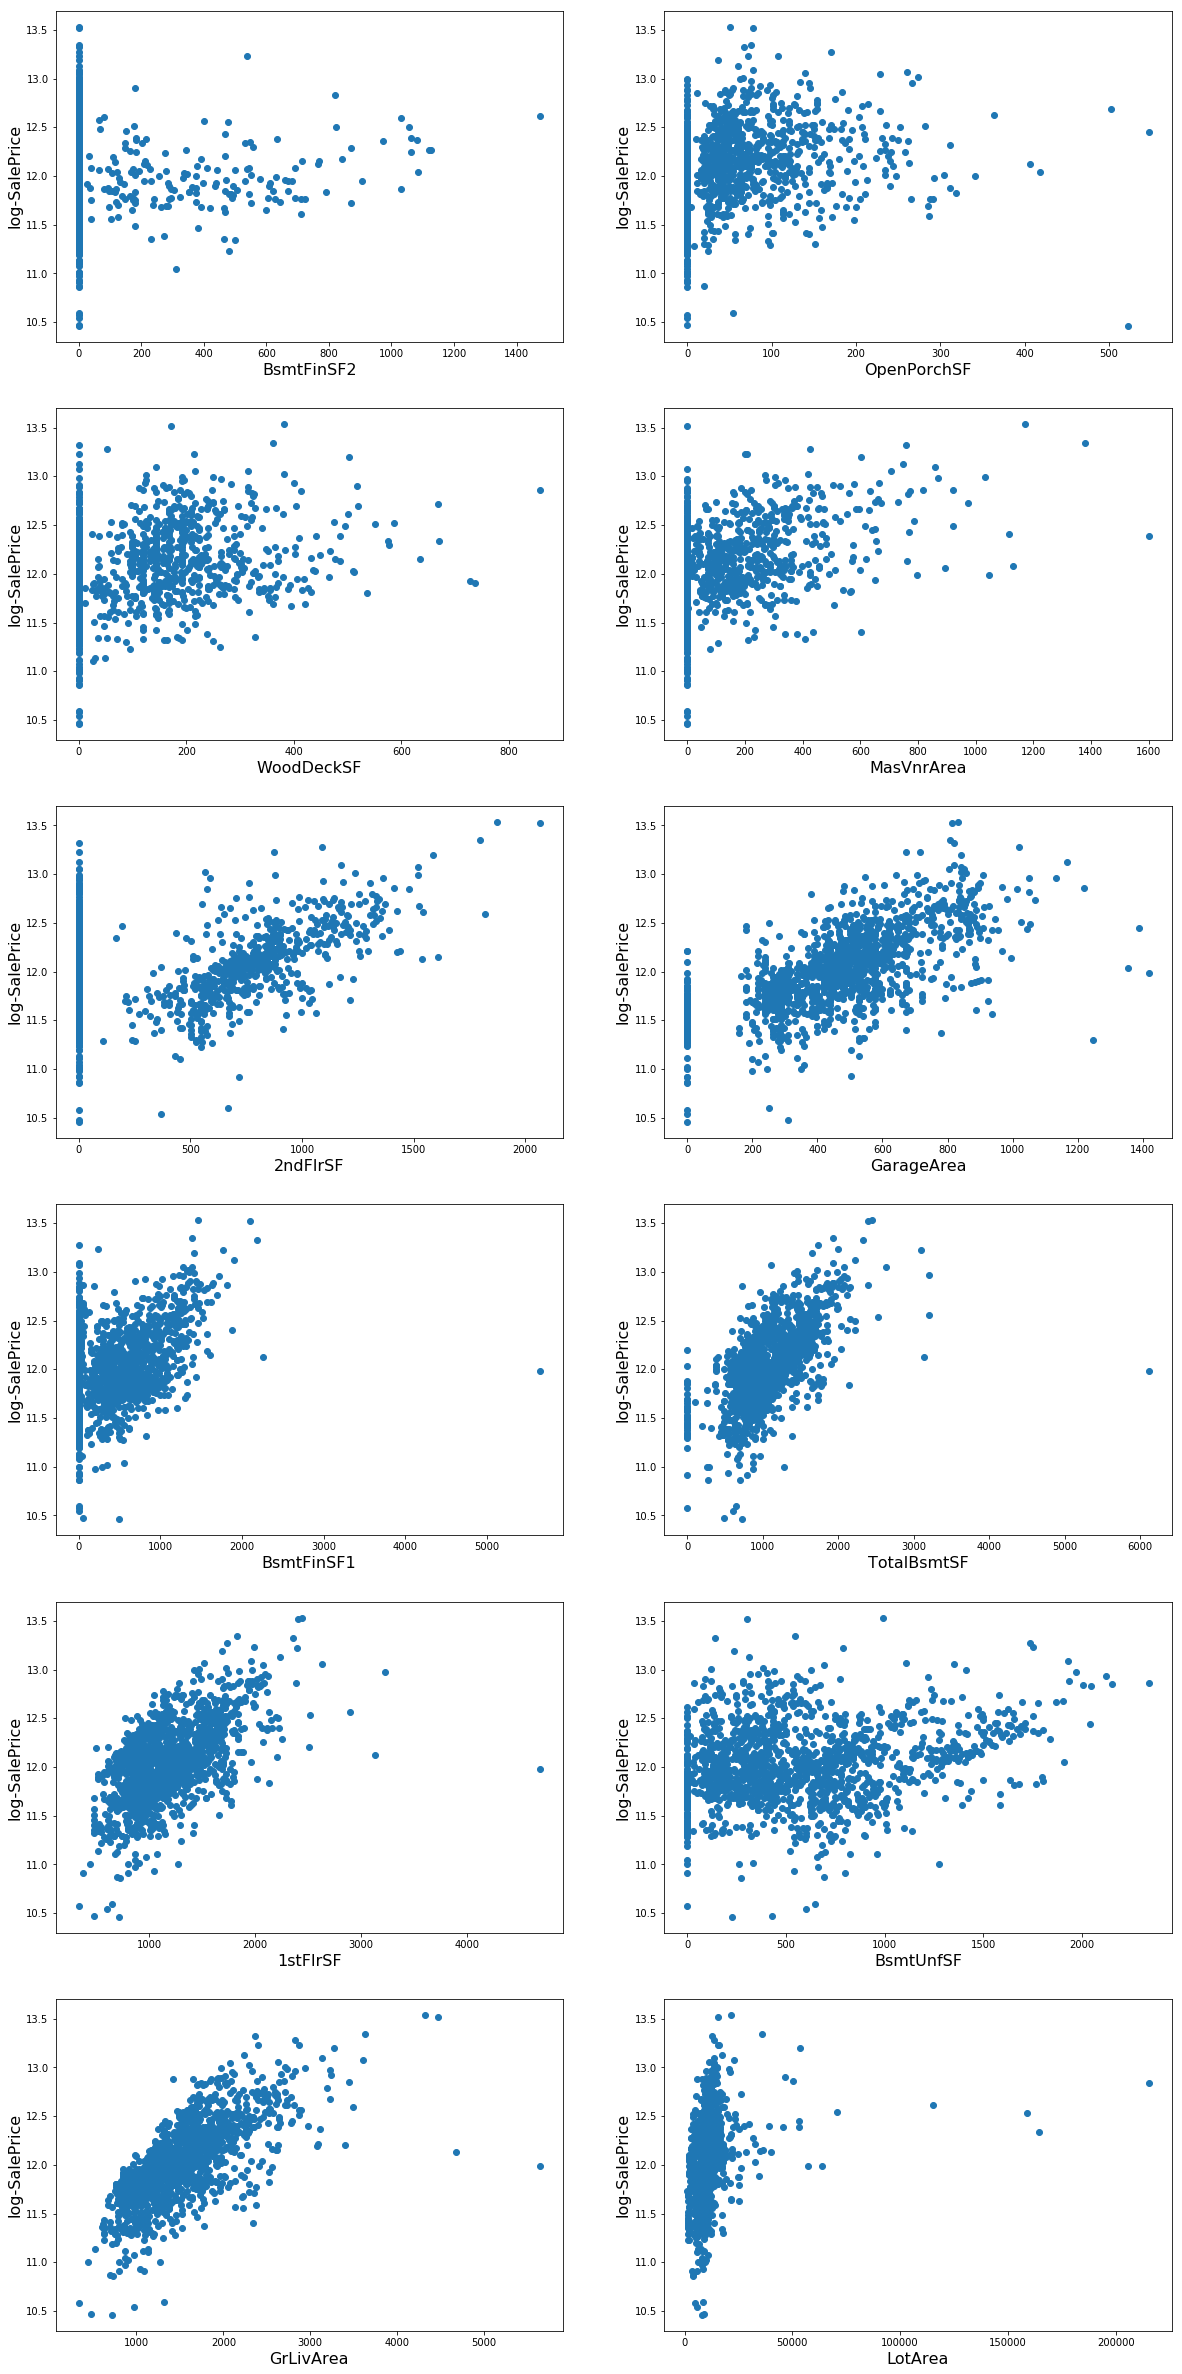

In [4]:
select_columns = unique_feature_numbers[unique_feature_numbers>120].drop(['Id','SalePrice']).index

total_columns = len(select_columns)
row_plot = total_columns/2+1

plt.figure(figsize = (20,50))
for i,col in enumerate(select_columns):
        
    plt.subplot(row_plot,2,i+1)
    plt.scatter(boston_house_train[col], np.log(boston_house_train['SalePrice']))
    plt.xlabel(col, fontsize=16)
    plt.ylabel('log-SalePrice', fontsize=16)

In [5]:
# GrLivArea >4500 砍掉!
# LotArea >100000 砍掉!
# 1stFlrSF >3500 砍掉
# GarageArea >1200 砍掉!

delete_idx = boston_house_train[(boston_house_train.GrLivArea>4500)|(boston_house_train.LotArea>100000)|(
                                boston_house_train['1stFlrSF']>3500)|(boston_house_train.GarageArea>1200)].index

print(delete_idx)

Int64Index([249, 313, 335, 523, 581, 706, 825, 1061, 1190, 1298], dtype='int64')


In [6]:
boston_house_train = boston_house_train.drop(delete_idx)

In [7]:
train_y = boston_house_train['SalePrice']

boston_house = pd.concat([boston_house_train.drop('SalePrice', axis = 1), boston_house_test],
                         sort = False).reset_index(drop = True)

---

## 特徵處理-資料視覺化(盒型圖)

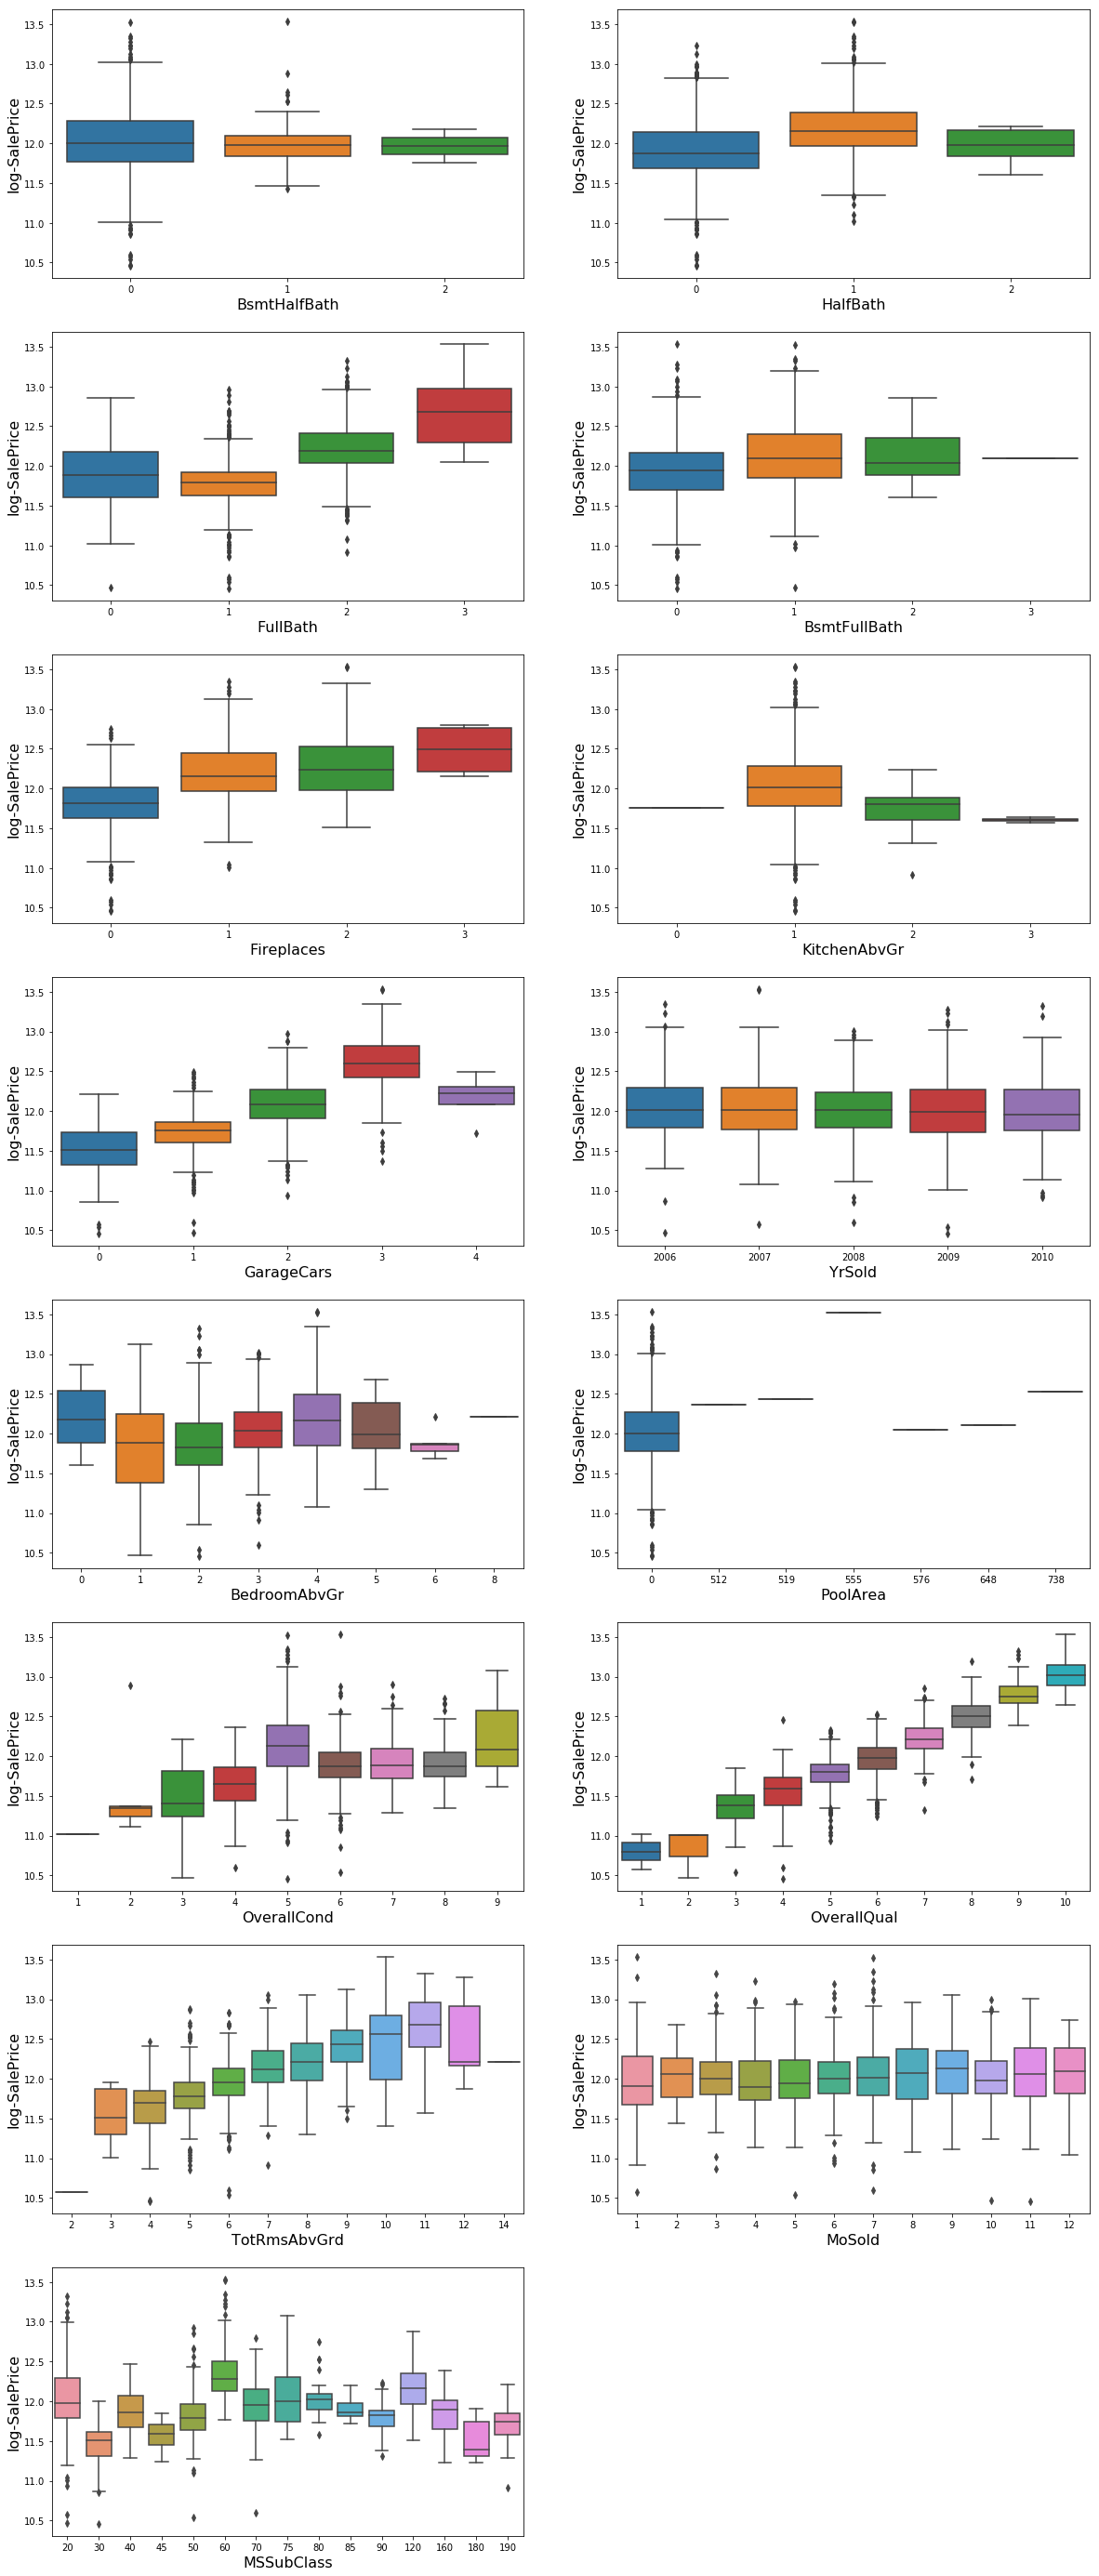

In [8]:
select_columns = unique_feature_numbers[unique_feature_numbers<20].index

total_columns = len(select_columns)
row_plot = total_columns/2+1

plt.figure(figsize = (20,50))
for i,col in enumerate(select_columns):
        
    plt.subplot(row_plot,2,i+1)
    sns.boxplot(x = boston_house_train[col], y = np.log(boston_house_train['SalePrice']))
    plt.xlabel(col, fontsize=16)
    plt.ylabel('log-SalePrice', fontsize=16)

In [9]:
boston_house['MoSold'] = boston_house['MoSold'].astype('object')
boston_house['YrSold'] = boston_house['YrSold'].astype('object')
boston_house['MSSubClass'] = boston_house['MSSubClass'].astype('object')

---

## 特徵處理 - 新變項

In [10]:
boston_house['Remodel_or_not'] = (boston_house['YearRemodAdd'] == boston_house['YearBuilt'])*1
boston_house['total_indoor_Square_Feet'] = boston_house['TotalBsmtSF']+boston_house['1stFlrSF']+boston_house['2ndFlrSF']
boston_house['total_outer_square_feet'] = boston_house[['LotArea','GarageArea','PoolArea']].fillna(0.0).sum(axis = 1)
boston_house['house_age'] = boston_house['YrSold']-boston_house['YearBuilt']

## 特徵處理 - 資料標準化

In [11]:
normalize_data = boston_house.fillna(0.0).copy()

for col in normalize_data.select_dtypes(include='number').columns:
    mms = MinMaxScaler()
    normalize_data[col] = mms.fit_transform(normalize_data[[col]])

## 特徵處理 - 合併組別

In [12]:
normalize_data['MSZoning'][normalize_data['MSZoning']==0] = 'RL'
normalize_data.loc[normalize_data['LotShape']=='IR3','LotShape'] = 'IR2'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 特徵處理 - One Hot Encoding

In [13]:
onehot_encode_data = pd.get_dummies(normalize_data)

---

## Build Model

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#注意，這邊因為做過極端值刪除因此資料筆數會有錯誤
train_len = len(boston_house_train)

train_x = onehot_encode_data.iloc[:train_len,:].drop('Id', axis = 1)
test_x = onehot_encode_data.iloc[train_len:,:].drop('Id', axis = 1)

t_x, v_x, t_y, v_y = train_test_split(train_x, train_y, test_size = 0.2, shuffle = True, random_state = 2019)

model = RandomForestRegressor(random_state = 2019)
model.fit(t_x, t_y)

print('Validation Score : %.4f'%model.score(v_x, v_y))

fe = pd.DataFrame({'colname':t_x.columns, 'importance':model.feature_importances_})

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Validation Score : 0.9042


In [15]:
fe.sort_values('importance')

,colname,importance
155,Exterior2nd_Brk Cmn,0.000000
138,Exterior1st_AsphShn,0.000000
139,Exterior1st_BrkComm,0.000000
59,Utilities_NoSeWa,0.000000
58,Utilities_AllPub,0.000000
57,Utilities_0.0,0.000000
141,Exterior1st_CBlock,0.000000
144,Exterior1st_ImStucc,0.000000
152,Exterior2nd_0.0,0.000000
270,GarageQual_Gd,0.000000


In [16]:
important_feature = fe[fe.importance>1e-7]
important_feature.shape

(234, 2)

In [17]:
model = RandomForestRegressor(random_state = 2019)
model.fit(t_x[important_feature.colname], t_y)

print('Validation Score : %.4f'%model.score(v_x[important_feature.colname], v_y))

pred_v = model.predict(v_x[important_feature.colname])

pred_test = model.predict(test_x[important_feature.colname])

Validation Score : 0.8906


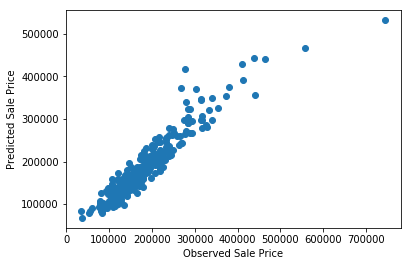

R2 score of validation set: 0.891
log-RMSE of validation set: 0.146


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(v_y, pred_v)
plt.xlabel('Observed Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

print('R2 score of validation set: %.3f'%r2_score(y_true = v_y, y_pred = pred_v))
print('log-RMSE of validation set: %.3f'%(mean_squared_error(y_true = np.log(v_y), y_pred = np.log(pred_v)))**0.5)


In [19]:
submission = pd.read_csv('data/boston/sample_submission.csv')

submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [20]:
submission['SalePrice'] = pred_test

submission.head()

,Id,SalePrice
0,1461,134525.0
1,1462,166230.0
2,1463,179050.0
3,1464,180800.0
4,1465,192670.6


In [21]:
submission.to_csv('submission_advance.csv', index = False)